In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/content/data_famd.csv", sep=";")  # <-- replace with your CSV path
# If CSV uses ; as separator, keep sep=";", otherwise default is sep=","

# Encode labels: No_Displ -> 0, Displ -> 1
df['Y'] = df['Y'].map({"No_Displ": 0, "Displ": 1})

# Features and labels
X = torch.tensor(df[['FAMD_1','FAMD_2','FAMD_3','FAMD_4']].values, dtype=torch.float32)
y = torch.tensor(df['Y'].values, dtype=torch.float32).view(-1,1)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check the distribution
print("\nTrain label distribution:\n", y_train.view(-1).to(torch.int64).bincount())
print("Test label distribution:\n", y_test.view(-1).to(torch.int64).bincount())

X_train shape: torch.Size([20625, 4])
y_train shape: torch.Size([20625, 1])
X_test shape: torch.Size([5157, 4])
y_test shape: torch.Size([5157, 1])

Train label distribution:
 tensor([10400, 10225])
Test label distribution:
 tensor([2600, 2557])


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Input: 4 features
        self.layer1 = nn.Linear(4, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.layer2 = nn.Linear(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.layer3 = nn.Linear(64, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.layer4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.layer5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.layer6 = nn.Linear(32, 16)
        self.output = nn.Linear(16,1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.relu(self.bn4(self.layer4(x)))
        x = self.relu(self.bn5(self.layer5(x)))
        x = self.relu(self.layer6(x))
        x = self.output(x)
        x = self.sigmoid(x)
        return x


# Instantiate the network
model = SimpleNN()
print(model)


SimpleNN(
  (layer1): Linear(in_features=4, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=32, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=64, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer6): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)


In [ ]:
criterion = nn.BCELoss()  # since we have sigmoid in output
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# -------------------------
# 4️⃣ Training loop with metrics
# -------------------------
num_epochs = 500
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_pred = (outputs >= 0.5).float()
    train_acc = (train_pred == y_train).sum().item() / y_train.size(0)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_pred = (val_outputs >= 0.5).float()
        val_acc = (val_pred == y_test).sum().item() / y_test.size(0)

    # Store metrics
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"loss: {loss.item():.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss.item():.4f} - val_accuracy: {val_acc:.4f}")





Epoch [10/500] - loss: 0.6462 - accuracy: 0.6786 - val_loss: 0.6918 - val_accuracy: 0.5042
Epoch [20/500] - loss: 0.6133 - accuracy: 0.7024 - val_loss: 0.6807 - val_accuracy: 0.5346
Epoch [30/500] - loss: 0.5818 - accuracy: 0.7192 - val_loss: 0.6567 - val_accuracy: 0.6031
Epoch [40/500] - loss: 0.5540 - accuracy: 0.7239 - val_loss: 0.6226 - val_accuracy: 0.6608
Epoch [50/500] - loss: 0.5300 - accuracy: 0.7340 - val_loss: 0.5965 - val_accuracy: 0.6769
Epoch [60/500] - loss: 0.5118 - accuracy: 0.7506 - val_loss: 0.5563 - val_accuracy: 0.7175
Epoch [70/500] - loss: 0.4981 - accuracy: 0.7614 - val_loss: 0.5257 - val_accuracy: 0.7322
Epoch [80/500] - loss: 0.4900 - accuracy: 0.7666 - val_loss: 0.5185 - val_accuracy: 0.7442
Epoch [90/500] - loss: 0.4807 - accuracy: 0.7693 - val_loss: 0.5042 - val_accuracy: 0.7634
Epoch [100/500] - loss: 0.4688 - accuracy: 0.7731 - val_loss: 0.4929 - val_accuracy: 0.7615
Epoch [110/500] - loss: 0.4829 - accuracy: 0.7658 - val_loss: 0.5034 - val_accuracy: 0.74


Train Confusion Matrix:
 [[8860 1540]
 [2108 8117]]

Validation Confusion Matrix:
 [[2117  483]
 [ 552 2005]]


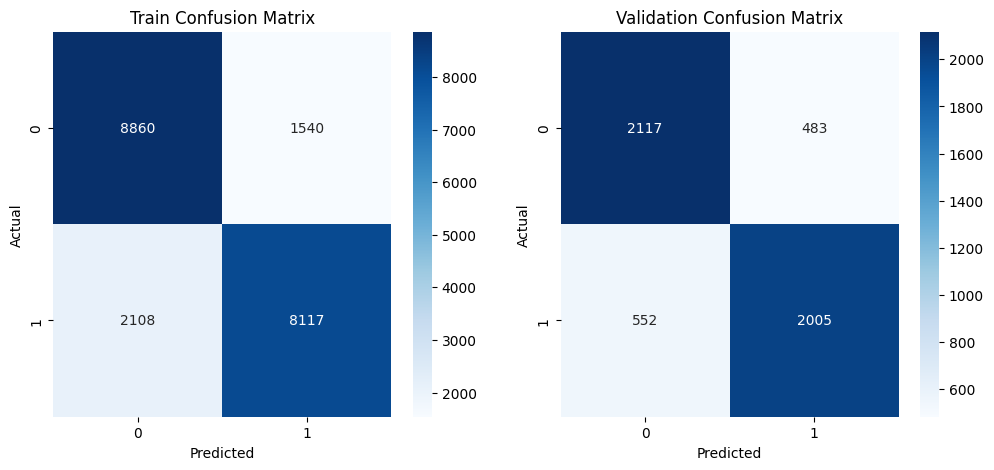

In [ ]:
# -------------------------
# 5️⃣ Confusion Matrices
# -------------------------
train_cm = confusion_matrix(y_train.numpy(), train_pred.numpy())
val_cm = confusion_matrix(y_test.numpy(), val_pred.numpy())

print("\nTrain Confusion Matrix:\n", train_cm)
print("\nValidation Confusion Matrix:\n", val_cm)

# Optional heatmap visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

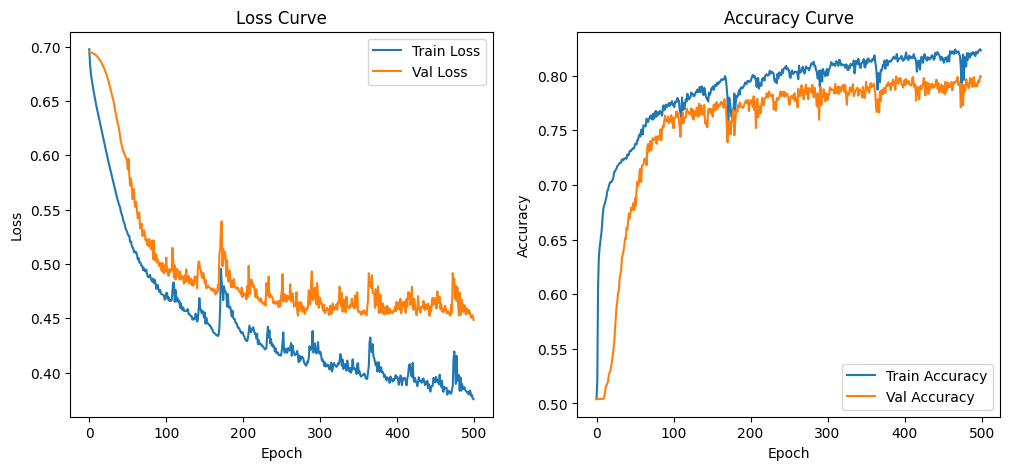

Model saved as deepnn_model.pt


In [ ]:
# -------------------------
# 6️⃣ Loss & Accuracy Curves
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# -------------------------
# 7️⃣ Save the trained model
# -------------------------
torch.save(model.state_dict(), "/content/deepnn_model.pt")
print("Model saved as deepnn_model.pt")


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test.numpy(), val_pred.numpy(), target_names=["No_Displ","Displ"]))


              precision    recall  f1-score   support

    No_Displ       0.79      0.81      0.80      2600
       Displ       0.81      0.78      0.79      2557

    accuracy                           0.80      5157
   macro avg       0.80      0.80      0.80      5157
weighted avg       0.80      0.80      0.80      5157

